# Check GPU
```
watch nvidia-smi
```

In [2]:
file_num = 0

# Import Library

In [1]:
import tensorflow as tf
import re, json, pickle
from tqdm import tqdm
import numpy as np
import tensorflow_hub as hub
from keras.utils.vis_utils import plot_model
from keras.layers import merge
import pathlib
import matplotlib.pyplot as plt
import time

# Set File Path

In [3]:
pre_path = "/content/drive/MyDrive/Special_Topic/Dataset/MSCOCO_2017/"
# image_path = "/content/drive/MyDrive/University/Special_Topic/Dataste/MSCOCO/MSCOCO_2017/val2017"
image_path =  pre_path + "val2017/"
anno_path = pre_path + '2017_annotations/captions_train2017.json'
glove_path = pre_path + 'GloVe.6B/glove.6B.300d.txt'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

In [5]:
caption_max_length = 30 # the maxinmun of each cation
start= "<sos>"
end = "<end>"
pad = "<pad>"
unk = "<unk>"
pooled_height = 14
pooled_width = 14# Create feature map input
num_of_object = 20
voc_size = 10193

dimensional = 1024
embedding_size = 300
# embedded_matrix_dimensional = 300

# Model

### Top_Down_Attention_LSTM: LSTM

In [ ]:
class Attention_LSTM(tf.keras.layers.Layer):
  """
    inputs[0] -> mean_pooled_image_feature (batch_size, dimension)
    inputs[1] -> text_embedding (batch_size, embedding_size)
    inputs[2] -> language_lstm_carry_state (batch_size, dimension)
    inputs[3] -> attention_lstm_hidden_state (batch_size, dimension)
    inputs[4] -> attention_lstm_hidden_state (batch_size, dimension)
    
    outputs[0] -> attention_lstm_hidden_state (batch_size, dimension)
    outputs[1] -> attention_lstm_carry_state (batch_size, dimension)
  """
  def __init__(self, name = 'Top_Down_Attention_LSTM', **kwargs):
    super(Attention_LSTM, self).__init__(name = name, **kwargs)
  def build(self, input_shape):
    self.batch_size = input_shape[0][0]
    self.dimensional = input_shape[0][1]
    self.cell = tf.keras.layers.LSTMCell(
        self.dimensional,
        dropout=0.5,
        recurrent_dropout=0.5, 
        name = 'attention_lstm_cell',
    )

  def compute_output_shape(self, input_shape):
      return (self.batch_size, 1, 1, self.dimensional)
      
  def call(self, inputs):
    # print(inputs)
    con_x = tf.concat([inputs[0], inputs[1], inputs[2]], axis = -1)
    state = [inputs[3], inputs[4]]
    out, state = self.cell(con_x, state)

    return (state[0], state[1])

### Attention_Layer

In [ ]:
class Attention_Layer(tf.keras.layers.Layer):
  """
    inputs[0] -> attention_lstm_hidden_state (batch_size, dimension)
    inputs[1] -> roi_pooling_image_feature (batch_size, , num_of_object,dimension)
    
    outputs[0] -> (batch_size, dimension)
  """
  def __init__(self, name = 'Attention_Layer', **kwargs):
    super(Attention_Layer, self).__init__(name = name, **kwargs)

  def build(self, input_shape):
    self.batch_size = input_shape[0][0]
    self.dimensional = input_shape[0][1] # For example VGG16, its dimensional is 512
    self.num_of_object = input_shape[1][1] # For exampel, we have number kinds of feature, like 'peopel', 'base', 'ball', etc.
    self.concate_feature_hidden = tf.keras.layers.Concatenate(axis = -1, name = 'feature_hidden')
    self.concate_hidden = tf.keras.layers.Concatenate(axis = 1, name = 'hidden')
    self.TimeDistributed_for_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    self.Dense_for_distribution = tf.keras.layers.Dense(self.num_of_object, activation = 'softmax', name = 'distribution')
  
  def compute_output_shape(self, input_shape):
    return (self.batch_size, 1, self.dimensional)
    
  def call(self, inputs):
    ex_hidden = tf.expand_dims(inputs[0], 1)
    new_hidden = ex_hidden
    for _ in range(self.num_of_object - 1):
      new_hidden = self.concate_hidden([new_hidden, ex_hidden])
    tmp_in = self.concate_feature_hidden([inputs[1], new_hidden])
    score = self.TimeDistributed_for_output(tmp_in)
    score = tf.reduce_sum(score, -1)
    distribute = self.Dense_for_distribution(score)
    out = tf.expand_dims(distribute, -1) * inputs[1]
    out = tf.reduce_sum(out,axis=-2)
    return out

### Language_LSTM



In [ ]:
class Language_LSTM(tf.keras.layers.Layer):
  """
    inputs[0] -> output_of_attention_layer (batch_size, dimension)
    inputs[1] -> attention_lstm_hidden_state (batch_size, dimension)
    inputs[2] -> language_lstm_hidden_state (batch_size, dimension)
    inputs[3] -> language_lstm_carry_state (batch_size, dimension)

    outputs[0] -> attention_lstm_hidden_state (batch_size, dimension)
    outputs[1] -> attention_lstm_carry_state (batch_size, dimension)
  """
  def __init__(self, name = 'Language_LSTM', **kwargs):
    super(Language_LSTM, self).__init__(name = name, **kwargs)
  
  def build(self, input_shape):
    self.batch_size = input_shape[0][0]
    self.dimensional = input_shape[1][1]
    self.cell = tf.keras.layers.LSTMCell(
        self.dimensional,
        dropout=0.5,
        recurrent_dropout=0.5, 
        name = 'language_lstm_cell',
    )


  def compute_output_shape(self, input_shape):
    return (self.batch_size, 1, self.dimensional)

  def call(self, inputs):
    con_x = tf.concat([inputs[0], inputs[1]], axis = -1)
    state = [inputs[2], inputs[3]]
    out, state = self.cell(con_x, state)
    return (state[0], state[1])

### Final Model

In [ ]:
class Top_Down_Buttom_Up_Model(tf.keras.Model):
  """
    input[0] -> mean_pooled_image_feature (32, 1024)
    input[1] -> roi_pooling_image_feature (32, num_of_object, 1024)
    input[2] -> Embedding_text (32, 30, 100)

  """
  def __init__(self, input_shape = [(dimensional), (num_of_object, dimensional), (caption_max_length, embedding_size)], name = 'Top_Down_Buttom_Up_Model', **kwargs):
      super(Top_Down_Buttom_Up_Model, self).__init__(name = name, **kwargs)
      

  def summary(self, input_shape = [(dimensional), (num_of_object, dimensional), (caption_max_length, embedding_size)]):
      input_layer = [tf.keras.layers.Input(shape = input_shape[i], batch_size = 32) for i in range(len(input_shape))]
      # input_layer = [tf.keras.layers.Input(shape = input_shape[i]) for i in range(len(input_shape))]
      self.build([input_layer[i].shape for i in range(len(input_layer))])
      out = self.call(input_layer)
      model = tf.keras.Model(inputs=input_layer, outputs=out)
      return model.summary()

  def build(self, input_shape):
    self.batch_size = input_shape[0][0]
    self.dimensional = input_shape[0][1]
    self.number_of_word_in_caption = input_shape[2][-2]
    self.num_of_object = input_shape[1][1]
    self.dropout_image_feature = tf.keras.layers.Dropout(0.5, name = 'Dropout_image_feature')

    self.top_down_attention_lstm = Attention_LSTM()
    self.attention_layer = Attention_Layer()
    self.language_lstm = Language_LSTM()
    
    self.dense_ini_hidden_state = tf.keras.layers.Dense(self.dimensional, name='ini_hidden_state')
    self.concate_hidden_language_lstm = tf.keras.layers.Concatenate(axis = 1)

    self.TimeDistributed_for_dropout = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.85), name = 'dropout_time')
    self.TimeDistributed_for_output_Layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(voc_size, activation='softmax',name='output_Layer'))
    
  def call(self, inputs):
    # drop1 = self.dropout_image_feature(inputs[0])
    # hidden_language_lstm = self.dense_ini_hidden_state(drop1)
    # print(inputs)
    image_feature = inputs[0]
    language_lstm_hidden_state = image_feature
    language_lstm_carry_state = image_feature
    attention_lstm_carry_state = image_feature
    attention_lstm_hidden_state = image_feature
    hidden_language_lstm_buffer = None

    for i in range(self.number_of_word_in_caption):
      # attention_lstm_hidden_state (batch_size, dimension), attention_lstm_carry_state (batch_size, dimension)
      (attention_lstm_hidden_state, attention_lstm_carry_state) = self.top_down_attention_lstm([
                                                                                                inputs[0], 
                                                                                                inputs[2][:, i, :], 
                                                                                                language_lstm_hidden_state, 
                                                                                                attention_lstm_hidden_state, 
                                                                                                attention_lstm_carry_state
                                                                                              ])
      
      out_attention_layer = self.attention_layer([attention_lstm_hidden_state, inputs[1]]) # out_attention_layer (batch_size, dimension)
      
      # hidden_language_lstm (batch_size, dimension), cell_language_lstm (batch_size, dimension)
      (language_lstm_hidden_state, language_lstm_carry_state) = self.language_lstm([
                                                                        out_attention_layer, 
                                                                        attention_lstm_hidden_state, 
                                                                        language_lstm_hidden_state, 
                                                                        language_lstm_carry_state
                                                                      ])
      
      if hidden_language_lstm_buffer == None:
        hidden_language_lstm_buffer = tf.expand_dims(language_lstm_hidden_state, 1)
        continue
      hidden_language_lstm_buffer = tf.concat([
                                                hidden_language_lstm_buffer, 
                                                tf.expand_dims(language_lstm_hidden_state, 1)
                                              ], axis = 1)
    
    out_TimeDistributed_for_dropout = self.TimeDistributed_for_dropout(hidden_language_lstm_buffer)
    out_TimeDistributed_for_output_Layer = self.TimeDistributed_for_output_Layer(out_TimeDistributed_for_dropout)
    
    return out_TimeDistributed_for_output_Layer


In [ ]:
text_embedding = tf.keras.layers.Input(shape = (30, embedding_size), batch_size=32, name = 'text_embedding')
mean_pooling_image_feature_1 = tf.keras.layers.Input(shape = (num_of_object, dimensional), batch_size=32,name = 'roi_pooling_image_feature')
mean_pooled_image_feature_2 = tf.keras.layers.Input(shape = (dimensional), batch_size=32,name = 'mean_pooled_image_feature')
hidden_1 = tf.keras.layers.Input(shape = (dimensional), batch_size=32,name = 'hidden_1')
hidden_2 = tf.keras.layers.Input(shape = (dimensional), batch_size=32,name = 'hidden_2')
cell_1 = tf.keras.layers.Input(shape = (dimensional), batch_size=32,name = 'cell_1')
cell_2 = tf.keras.layers.Input(shape = (dimensional), batch_size=32,name = 'cell_2')

### Test For Model



In [ ]:
model = Top_Down_Buttom_Up_Model()
out = model([mean_pooled_image_feature_2, mean_pooling_image_feature_1, text_embedding])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(32, 30, 300)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(32, 1024)]         0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (32, 300)           0           ['input_3[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 Top_Down_Attention_LSTM (Atten  ((32, 1024),        13815808    ['input_1[0][0]',            

# Preprocessing

In [9]:
with open('/content/drive/MyDrive/Special_Topic/Top_Down_Bttom_Up/Code/Dataset/train_val_dataset.pickle', 'rb') as f:
# with open('/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo2/Dataset/train_val_dataset_for_make_model.pickle', 'rb') as f:
  dataset = pickle.loads(f.read())

In [10]:
dataset.keys()

dict_keys(['train', 'val'])

In [11]:
for i in dataset.keys():
  if i == 'image_id':
    print(i, len(dataset[i]))
    continue
  print(i, len(dataset[i]['image_id']))

train 43000
val 7000


# Model.fit

In [6]:
model_save_file = "/content/drive/MyDrive/Special_Topic/Top_Down_Bttom_Up/Code/Model_Backup/model_top_down_buttom_up_" + str(file_num)
# model_save_file = "/content/drive/MyDrive/Special_Topic/Code/Final/Demo8/Model_Backup/model_top_down_buttom_up_2"

In [ ]:
try:
  model.built = True
  model.load_weights(model_save_file + '.h5')
  print('old model')
except:
  print('new model')
  model = Top_Down_Buttom_Up_Model()

In [ ]:
ts = time.time()
# model = Top_Down_Buttom_Up_Model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue = 1.0)
model.compile(
      loss='sparse_categorical_crossentropy', 
      optimizer=opt, 
      # metrics=['sparse_categorical_accuracy']

      )
my_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      model_save_file + ".h5", 
      monitor='val_loss', 
      verbose=1, 
      save_best_only=True, 
      mode='auto', 
      save_weights_only=True,
      period=1
)
my_earlyshopping = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
result = model.fit(
      [dataset['train'][i] for i in ['mean_pooled_image_feature_2','mean_pooled_image_feature_1', 'text_embedding']],
      [dataset['train'][i] for i in ['label']],
      # epochs=50,
      # epochs=1,
      validation_data=(
            [dataset['val'][i] for i in ['mean_pooled_image_feature_2', 'mean_pooled_image_feature_1','text_embedding']],
            [dataset['val'][i] for i in ['label']],
      ),
      epochs=100,
      batch_size = 32,
      validation_batch_size = 32,
      # shuffle = False,
      callbacks=[
                 my_checkpoint, 
                #  my_earlyshopping,
                 ]
      )
outfile = open(model_save_file + '_history.plk','wb')
pickle.dump(result.history, outfile)
outfile.close()

t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

In [ ]:
# try:
#   with open(model_save_file + '_history.plk', 'rb') as f:
#     print('load old history')
#     history = pickle.loads(f.read())
# except:
#   print('new history')
#   history = list()
# history.append(result.history)
# outfile = open(model_save_file + '_history.plk','wb')
# pickle.dump(history, outfile)
# outfile.close()

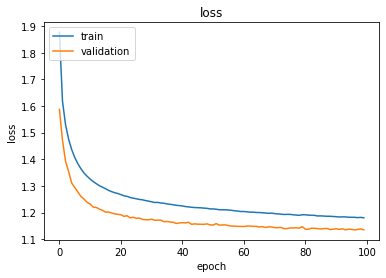

In [8]:
# summarize history for loss
with open(model_save_file + '_history.plk', 'rb') as f:
  # if f.is_file():
    history = pickle.loads(f.read())
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Test

### Load Model

In [ ]:
# model = Top_Down_Buttom_Up_Model()
model.built = True
model.load_weights('/content/drive/MyDrive/Special_Topic/Top_Down_Bttom_Up/Code/Model_Backup/model_top_down_buttom_up_' + str(file_num) + '.h5')

### Make word_index and index_word

In [ ]:
path = '/content/drive/MyDrive/Special_Topic/Dataset/new_dataset2/word_index_and_index_word.pkl'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    data = pickle.loads(f.read())
    word_index = data['word_index']
    index_word = data['index_word']

### Make testx and testy

In [ ]:
path = '/content/drive/MyDrive/Special_Topic/Top_Down_Bttom_Up/Code/Dataset/test_dataset.pickle'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    # data = pickle.loads(f.read())
    testx = pickle.loads(f.read())

### Make Embedding Layer


In [ ]:
f = open(glove_path,encoding="utf-8")
embedded_vector_index = {}
for i in f:
  values = i.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedded_vector_index[word] = coefs

embedded_matrix = np.zeros((voc_size,embedding_size))
n = 0
for word, i in word_index.items():
    embedding_vector = embedded_vector_index.get(word)
    if embedding_vector is not None: #不能map到的word為0向量
      embedded_matrix[i] = embedding_vector
      n += 1
    else:
      embedded_matrix[i] = np.random.randn(embedding_size)
emb = tf.keras.layers.Embedding(voc_size, embedding_size, mask_zero=True,name='Embedding_layer', trainable=False, weights=[embedded_matrix])

### Start Predict

In [ ]:
def predict(data):
  # predict_y = list()
  for i in range(0,30):
    testy = model.predict(data)
    if i == 29:
      break
    token_cur = np.argmax(testy,axis=2)
    tmp = emb(np.array([[token_cur[0][i]]]))
    data[2] = tf.get_static_value(data[2])
    # print(tf.get_static_value(tf.reshape(tmp, (embedding_size, ))))
    # print(data[0][i+1])
    data[2][0][i+1] = tf.get_static_value(tf.reshape(tmp, (embedding_size, )))
    data[2] = tf.constant(data[2])

  predict_text = ''
  token_cur = np.argmax(testy,axis=2) 
  for element in token_cur[0]:
    cur_word = index_word[element]
    if(cur_word == '<end>'):
      predict_text += '.'
      break
    if(cur_word != '<pad>'):
      predict_text += " " + cur_word
  if predict_text == '':
    return None 
  predict_text = predict_text[1].upper() + predict_text[2:]
  # predict_y.append(predict_text)
  # print(predict_text)
  
  return predict_text

In [ ]:
ts = time.time()

results = list()
error = list()
for i in range(len(testx['image_id'])):
  print(i)
  d = predict([ tf.expand_dims(testx[j][i], axis = 0) for j in ['mean_pooled_image_feature_2','mean_pooled_image_feature_1', 'text_embedding']] )
  if d == None:
    print('error')
    error.append(int(testx['image_id'][i]))
    continue
  predict_y = d
  print(predict_y)
  tmp = {
      'image_id': int(testx['image_id'][i]),
      'caption': predict_y
  }
  results.append(tmp)
  # break

t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

In [ ]:
error

In [ ]:
len(results)

In [ ]:
results_path = '/content/drive/MyDrive/Special_Topic/Top_Down_Bttom_Up/Code/Results/Top-down_results_' + str(file_num) + '.plk'
outfile = open(results_path,'wb')
pickle.dump(results, outfile)
outfile.close()